# SI 630 Homework 1 - Classification

Your task is to build a classifier to assess to what degree can we predict the political party of the sender from this type of messaging?

**Does the sender of the email belong to the Democratic or Republican Party**

Author: Samantha Ryan-Lee (sryanlee)

## Notebook Setup

1. import packages
2. global variable assignment
3. function definitions
4. read in data

### A Note on Notation:

Definitions: 

1. Classifier Features = **`x1, x2, ... xn ∈ X`** where **`X`** is the set of all features
    - **`∈`** = "an element of"
    - each feature, **`xn`**, corresponds to the presence of a word in a document
    - you can experiment with bigrams or trigrams in a later part of the assignment
2. Classifier Labels = **`y1, y2, ... yn ∈ Y`** where **`Y`** is the set of all labels
    - **`∈`** = "an element of"
    - each label, **`yn`**, corresponds to the political affiliation (party) of the email sender
    - since this is a binary classificaiton task, there are only 2 labels: **`y1, y2 ∈ Y`**
3. Probability **`P(X=xi|Y=yj)`** means "The probability that feature **`xi`** is true (present in the document) given that we have seen the class **`Y`** is **`yj`**"

### A. Import Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import nltk
import re
import scipy

### B. Assign Global Variables

In [2]:
TRAIN = pd.read_csv('train.csv', encoding='utf-8')
TEST = pd.read_csv('test.csv', encoding='utf-8')
DEV = pd.read_csv('dev.csv', encoding='utf-8')

In [3]:
punct = re.compile(r"([^\w\s<>\'])")
newline = re.compile(r"(\s\n\s)")
contraction = re.compile(r"(\'[a-z]{1,2}|[a-z]{1}\'[a-z]{1})")
empty_tag = re.compile(r"(\<\>)")

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
STOPWORDS.append('')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sryanlee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
MIN_WORD_FREQ = 10

### C. Function Definitions

Tokenization

In [6]:
def tokenize(document):
    """
    accepts a document string and tokenizes it by whitespace
    
    Note: You should use this function as you read in the training data so that each whitespace separated 
    word will be considered a different feature.
    ------------------------------------------------------------------
    returns a list of tokens
    ------------------------------------------------------------------
    example implementation: train['tokens'] = train.document.apply(tokenize)
    """
    tokens = document.split(' ')
    return tokens

In [7]:
def translate_contractions(match_obj):
    """
    accepts a re match object and checks if it falls into one of the common contraction patterns
    if it does, the contraction is translated into the full form and replaced in the text
    """
    match = match_obj.group(0)
    replace = ""
    if match == "n't" or match == "nt":
        replace = "not"
    elif match == "'re" or match == "re":
        replace = "are"
    elif match == "'ve" or match == "ve":
        replace = "have"
    elif match == "'s" or match == "s":
        replace = "is"
    elif match == "'d" or match == "d":
        replace = "would"
    elif match == "'ll" or match == "ll":
        replace = "will"
    elif match == "'m" or match == "m":
        replace = "am"
    else:
        pass
    return replace

In [8]:
def remove_stopwords(words):
    """
    accepts a list of cleaned words (tokens) and filters out stopwords
    ------------------------------------------------------------------
    words (list): a list of tokens
    STOPWORDS (global variable): stopwords from NLTK with an additional empty string "word" added
    ------------------------------------------------------------------
    returns a list of tokens without stopwords
    ------------------------------------------------------------------
    example implementation: train['tokens_nostop'] = train.document_word_list.apply(remove_stopwords)
    """
    tokens_nostop = []
    for token in words:
        if token not in STOPWORDS:
            tokens_nostop.append(token)
    return tokens_nostop

In [9]:
def better_tokenize(document, nostopwords=False):
    """
    accepts a document string and tokenizes it 
    i.e. lowercase, removed punctuation, translated contractions, removed stopwords, only keep unique words
    ------------------------------------------------------------------
    by default returns a list of improved tokens including stopwords
    assign nostopwords=True if stopwords are to be excluded in the tokens
    ------------------------------------------------------------------
    example implementation: train['better_tokens'] = train.document.apply(better_tokenize)
    """    
    lowerstrip = document.lower().strip()
    no_punct = punct.sub(' ',lowerstrip)
    no_newline = newline.sub(' ',no_punct)
    no_contractions = contraction.sub(translate_contractions,no_newline)
    no_empty_tag = empty_tag.sub(" ",no_contractions)
    better_tokens = re.split(r"\s+", no_empty_tag)
    better_tokens = list(filter(None, better_tokens))
    better_tokens_nostop = remove_stopwords(better_tokens)
    
    if nostopwords == True:
        return better_tokens_nostop
    else:
        return better_tokens

A Note Bag of Words Representation:
- each document (`email_text`) is represented as a vector **`x`** of length **`|V|`** (number of nuquie words across all documents)
- count how many times each word occurs in that document
    - so that **`xi`** is the number of times the word represented by column **`i`** occurs

An example

| document | the | quick | brown | dog | jumps | over | .... |
| --------------- | --- | ----- | ----- | --- | ----- | ---- | ---- |
| email 1 | 2 | 0 | 1 | 0 | 0 | 0| |
| email 2 | 2 | 1 | 0 | 0 | 1 | 0| |
| email 3 | 0 | 0 | 2 | 1 | 0 | 1| |

In [10]:
def build_vocabulary(corpus, filter_vocab=True, print_stats=False):
    """
    accepts a dict of document tokens and finds/extracts unique tokens occuring more than 10 times
    ------------------------------------------------------------------
    corpus (dictionary): document : list(tokens)
    ------------------------------------------------------------------
    returns a list of unique terms present in the corpus
    """
    vocabulary = {}
    for tokens in corpus.values():
        for token in tokens:
            if token not in vocabulary.keys():
                vocabulary[token] = 0
            elif token in vocabulary.keys():
                vocabulary[token] += 1
    
    filtered_vocabulary = []
    for token, count in vocabulary.items():
        if count >= MIN_WORD_FREQ:
            filtered_vocabulary.append(token)

    if print_stats == True:
        print(f"Total Corpus Vocabulary Length: {len(vocabulary)}")
        print('------------------------------------------------------------------')
        print(f"Filtered Corpus Vocabulary Length = {len(filtered_vocabulary)}")
        print('------------------------------------------------------------------')
        print(f"Filtered Corpus Vocabulary Sample:\n{filtered_vocabulary[::500]}")
        
    if filter_vocab == True:
        return filtered_vocabulary
    else:
        return vocabulary

In [11]:
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix

def build_dtm(document_token_dict):
    """
    accepts a document_id:token_list dictionary and creates:
    a vocabulary where each unique token across all documents is a vocabulary word with 
    corresponding counts filtered by a predefined minimum word frequency (MIN_TERM_FREQ), and
    a matrix where:
        each word in the vocabulary is a column and 
        each document is a row counting the frequency of a token appearing in the document.
    
    The matrix is built using numpy zero matrix, then converted to csc matrix so mathematical operations are more efficient 
    refer to link for additional details on sparse matrices
    https://datascience.stackexchange.com/questions/31352/understanding-scipy-sparse-matrix-types
    ------------------------------------------------------------------
    returns:
        sparse term-document matrix (csc_matrix), 
        filtered vocabulary dictionary (vocab_word:col_index), 
        document id vocabulary (doc_id:row_index)
    ------------------------------------------------------------------
    code adapted from 
    https://datascience.blog.wzb.eu/2016/06/17/creating-a-sparse-document-term-matrix-for-topic-modeling-via-lda/
    ------------------------------------------------------------------
    ideally vocabulary is built outside of this function, but it's just not going to happen right now.
    """
    # create vocabulary
    vocabulary = {}
    for document, tokens in document_token_dict.items():
        unique_tokens = set(tokens)
        for token in unique_tokens:
            if token not in vocabulary.keys():
                # if token does not already exist in vocabulary, add it to vocabulary and initialize frequency (count) to 1
                vocabulary[token] = 1
            elif token in vocabulary.keys():
                # if token already exists in vocabulary, increase frequency (count) by 1
                vocabulary[token] += 1

    # filter vocabulary based on MIN_WORD_FREQ and count nonzero values
    filtered_vocabulary = {'BIAS_TERM': 0} # vocab_word:col_index_value
    vocabulary_columns = {0: 'BIAS_TERM'} # col_index_value:vocab word
    col_index = 1
    n_nonzero_filtered = 0
    for token, count in vocabulary.items():
        if count >= MIN_WORD_FREQ:
            filtered_vocabulary[token] = col_index
            vocabulary_columns[col_index] = token
            col_index += 1
            n_nonzero_filtered += count

    doc_ids = {} # document_id:row_index_value
    doc_rows = {} # row_index_value:document_id
    row_index = 0
    for doc_id in document_token_dict.keys():
        doc_ids[doc_id] = row_index
        doc_rows[row_index] = doc_id
        row_index += 1

    #initialize doc term matrix with zeros using np zero array
    n_docs = len(doc_ids)
    n_vocab = len(filtered_vocabulary)
    counts_array = np.zeros((n_docs, n_vocab), dtype=np.intc)
    
    # update array data
    bias_index = filtered_vocabulary['BIAS_TERM']
    #print(f'bias_index: {bias_index}')
    for doc_id, tokens in document_token_dict.items():
        doc_index = doc_ids[doc_id]
        #print(f'doc_index: {doc_index}')
        counts_array[doc_index][bias_index] += 1
        #print(f'counts_array: {counts_array[doc_index][bias_index]}')
        for token in tokens: 
            if token in filtered_vocabulary.keys():
                token_index = filtered_vocabulary[token]
                counts_array[doc_index][token_index] += 1
    
    #convert counts_array to csc matrix
    dtm = csr_matrix(counts_array)
    
    return (dtm, filtered_vocabulary, doc_ids, vocabulary_columns, doc_rows)

**Sigmoid** Function
$$
S(X) = \frac{1}{1 + exp(-X)}\
$$

In [12]:
def sigmoid(doc_vector):
    """
    computes the sigmoid of a vector of document-term frequencies 
    X (np array): each document is a row and each value is the frequency in which a token (word) appears in the document.
    returns a vector of probabilities for each document
    Note: S(X) = \frac{1}{1 + exp(-X)}\
    """
    Yhat = 1 / (1 + np.exp(-1*doc_vector)) 
    return Yhat

In [13]:
def get_rand_index(X):
    """
    returns a randomly sampled document from an input document term matrix (X)
    """
    num_docs = X.shape[0]
    rand_doc_index = np.random.choice(num_docs, replace=False)
    rand_col_index = X[rand_doc_index].nonzero()
    return rand_doc_index, rand_col_index

**Log Likelihood** Formula (whole training data) 
- where $\beta$ is the vector of coefficients (weights)
$$
ll = \sum_{i=1,...,n} y_{i} \beta^{T} x_{i} - log(1 + exp(\beta^{T} x_{i}))
$$

**Log Likelihood** Formula (another version)
- You can use log-rules to prove this formula is the same as the Log Likelihood Formula for the whole training data set. 
$$
ll = \sum_{i=1,...,n} y_{i} \beta^{T} x_{i} = log(1 + exp(\beta^{T} x_{i}))
$$

**Loss Function** (a single sample)
- from SI511 notes
$$
l(\hat{y}, y_{i}) = - ( y_{i} log(\hat{y}) + (1 - y_{i}) log(1 - \hat{y}))
$$
    - Consider the following scenarios
        - IF $y_{i} = 1$ THEN $ll(\hat{y}, y_{i}) = - log(\hat{y})$
            - IF $\hat{y} = 1$ THEN $ll = 0$ (the loss is zero for correct predictions)
            - IF $\hat{y} = 0$ THEN $ll \to \infty$ (the loss approaches infinity (its huge) for completely incorrect predictions)
        - IF $y_{i} = 0$ THEN  $ll(\hat{y}, y_{i}) = - log(\hat{y})$
            - IF $\hat{y} = 0$ THEN $ll = 0$ (the loss is zero for correct predictions)
            - IF $\hat{y} = 1$ THEN $ll \to \infty$ (the loss approaches infinity (its huge) for completely incorrect predictions)

In [14]:
def log_likelihood(X, Y, Yhat, B, rand_doc_index):
    """
    calculates the log likelihood of the training data (X) given our parameters β.
    X (csr matrix): doc-term-matrix
    B (vector): Beta vector (coefficients)
    Log Loss is -1 * the log of the likelihood function.
    b = b + learning_rate * (y - yhat) * yhat * (1 - yhat) * x
    (y – yhat) is the prediction error for the model on the training data attributed to the weight
    yhat is the prediction made by the coefficients and x is the input value
    """
    xi = X[rand_doc_index]
    yi = Y[rand_doc_index]
    yi_hat = Yhat[rand_doc_index]

    likelihood = np.sum((yi - yi_hat)*xi)
    loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)

    return (likelihood, loss)

**Gradient Descent**
- Given some choice of $\beta$ to make predictions, we want to use the difference in our prediction $\hat{Y}$ from the ground truth $Y$ to update $\beta$.
- The gradient of the log likelihood tells us which direction (positive or negative) to make the update and how large the update should be.
$$
\Delta ll = X^{T}(Y - \hat{Y})
$$
- where $Y$ is the set of ground truth labels and $\hat{Y}$ is the set of predicted labels
- in this case compute the gradient of the likelihood one instance at a time, so you can calculate the gradient for how to update $\beta$ as:
$$
\frac{\delta}{\delta \beta}\ ll (\beta) = (\sigma (\beta x_{i}) - y_{i}) x_{i}
$$
- This equation tells us how close our binary prediction $\sigma (\beta x_{i})$ is to the ground truth $y_{i} - \sigma (\beta x_{i})$ and then uses the loss to scale the feature values of the current instance $x_{i}$ to see how to update $\beta$
    - this update tell us how to update $\beta$ so that it learns which features to weight more heavily and how to weight them (or conversely, which features to ignore!)
- When doing learning we’ll scale this gradient by the learning rate $\alpha$ to determine how much to update $\beta$ at each step as:
$$
\beta_{new} = \beta_{old} - \alpha \frac{\delta}{\delta\beta}\ ll (\beta)
$$

In [15]:
def compute_gradient(X, Y, Yhat, rand_doc_index):
    """
    computes the gradient of the β vector
    X (feature matrix): a document-term matrix where 
        each value is the frequency in which a token (word) appears in the document (row).
    Y (vector): vector of ground truth labels for the corresponding matrix
    Yhat (vector): vector of predicted labels probability for the corresponding matrix
    returns gradient (value): the coefficient to scale the features during the next selected document (row)
    """
    xi = X[rand_doc_index].toarray()
    yi = Y[rand_doc_index]
    yi_hat = Yhat[rand_doc_index]

    gradient = (yi_hat - yi) * xi
    
    return gradient

**Logistic Regression** Formula
$$
P(y=1|x,\beta) = \frac{1}{exp(- \sum^N_{i=1} x_{i} \beta_{i})}\
$$

In [16]:
def logistic_regression(X, Y, learning_rate, num_step, B=None): 
    """
    takes in a
    
    – a matrix X where each row is a vector that has the features for that instance 
        i.e. document term matrix
      
    – a vector Y containing the class of the row
        i.e. labels
    – learning rate which is a parameter to control how much you change the β values each step
        i.e. alpha
    – num step how many steps to update β before stopping
        i.e. number of emails to run through for updates before stopping the updating

    Your function should iteratively update the weight vector β at each step by making predictions,
    \hat{y_{i}}, for each row i of X and then using those predictions to calculate the gradient. 
    
    You should also include an intercept coefficient

    Note that you can make your life easier by using matrix operations. For example, to compute
    \hat{y_{i}}, multiply the row of matrix X by the β vector.
    """
    if B is None:
        B = np.ones(shape=X.shape[1])
    sigmoid_input = X.dot(B.T)
    Yhat = sigmoid(sigmoid_input)
    
    plot_intervals = np.arange(0, num_step, 100)
    loss_plot = {}
    likelihood_plot = {}

    for step in range(num_step): 
        rand_row_index, rand_col_index = get_rand_index(X)
        likelihood, loss = log_likelihood(X, Y, Yhat, B, rand_row_index)
        if step in plot_intervals:
            loss_plot[step] = loss
            likelihood_plot[step] = likelihood
            #print(f'STEP {step} COMPLETE')
            #print(f'likelihood: {likelihood}\nloss:{loss}')
            #print('--------------------------------------------------------------')

        gradient = compute_gradient(X, Y, Yhat, rand_row_index)
        B = B - learning_rate * gradient[0]
        X = X.multiply(B).tocsr()

        sigmoid_input = X.dot(B.T)
        Yhat = sigmoid(sigmoid_input)
        step += 1
        #print('--------------------------------------------------------------')
        
    trained_B = B

    return (X, Y, Yhat, trained_B, loss_plot, likelihood_plot)

In [17]:
def predict(corpus_dict, labels, beta):
    """
    given some new text, converts it to a vector (i.e., something like a row from X), 
    and then uses the β vector to predict the class and returns the class label.
    
    input: corpus_dict (doc id:token list dict), labels (list of ground-truth labels), beta (trained beta csr matrix)
    
    The model makes a prediction for a training instance, the error is calculated and the model is 
    updated in order to reduce the error for the next prediction.

    """
    dtm, dtm_vocab, dtm_docs, dtm_vocab_index, dtm_doc_index = build_dtm(corpus_dict)
    X = dtm.copy()
    Y = np.array(labels)
    sigmoid_input = X.dot(beta.T) # trained beta matrix
    Yhat = sigmoid(sigmoid_input)
    
    class_predictions = {}
    class_probabilities = {}
    true_labels = {}
    i = 0
    for proba in Yhat: 
        if proba < 0.5:
            class_predictions[dtm_doc_index[i]] = 0
            class_probabilities[dtm_doc_index[i]] = proba
            true_labels[dtm_doc_index[i]] = Y[i]
        else:
            class_predictions[dtm_doc_index[i]] = 1
            class_probabilities[dtm_doc_index[i]] = proba
            true_labels[dtm_doc_index[i]] = Y[i]
        i += 1
    
    return class_predictions, class_probabilities, true_labels


In [ ]:
def to_sparse_tensor(sparse_matrix):
    """
    takes the sparse numpy (SciPy) representation of the term-document matrix you used earlier 
    and converts it into sparse Tensor objects.
    """
    sparse_tensor = None
    return sparse_tensor

## Regex Testing

Regex pattern implementation

- punctuation: `[^\w\s<>\']`
    - does not consider important characters for future patterns such as tag markers and apostrophes (<, >, ')
- POS tags: `\<[A-Z]*\>`
    - drop empty tags and use others (count, avg, etc) as an additional feature?
    - keep actual POS tags as a 'word' 
- contractions: `[A-Za-z]+\s?\'\s?[a-z]{1,2}`
    - drop second half of contraction? usually stopwords like not, am, would, will, etc?
    - 'translate' second half of contraction? to avoid data loss? 
- newlines: `\\n` 
    - works in [testing](regex101.com) but not in implementation?

In [18]:
# train_regex_testing = TRAIN.copy()
# train_regex_testing['punctuation'] = train_regex_testing.email_text.str.findall(r"([^\w\s<>\'])")
# train_regex_testing['POS_tags'] = train_regex_testing.email_text.str.findall(r"(\<[A-Z]*\>)")
# train_regex_testing['contractions'] = train_regex_testing.email_text.str.findall(r"([A-Za-z]+\s?\'\s?[a-z]{1,2})")
# train_regex_testing['newline'] = train_regex_testing.email_text.str.findall(r"(\\n)")
# train_regex_testing.sample(5)

## Part 1: Representing Text Data

Transform text data into some numeric representation that classifiers can work with.
In this case a Bag of Words representation is used.

### 1.1. Tokenization

Use the appropriate function to tokenize each document (`email_text`) in the corpus (`train`)
1. First use `tokenize`
2. Later on use `better_tokenize`

In [19]:
df = TRAIN.copy()
df['email_tokens'] = df.email_text.apply(tokenize)

In [20]:
df['email_better_tokens'] = df.email_text.apply(better_tokenize)

In [21]:
df['email_better_tokens_nostopwords'] = df.email_text.apply(better_tokenize, nostopwords=True)

In [22]:
df.sample(5)

,party_affiliation,email_text,uid_email,email_tokens,email_better_tokens,email_better_tokens_nostopwords
53100,Republican Party,"<PERSON> Dems are trying to trick <> \n <>, \...",3bd13e285e56857a29479de65a4f9d48,"[<PERSON>, Dems, are, trying, to, trick, <>, \...","[<person>, dems, are, trying, to, trick, and, ...","[<person>, dems, trying, trick, pals, <gpe>, p..."
9210,Democratic Party,We 're polling the top[ 100] <> <NORP>. \n Br...,8f4ab0cd2195dd90007e65b5c1890a8b,"[We, 're, polling, the, top[, 100], <>, <NORP>...","[we, are, polling, the, top, 100, <norp>, brea...","[polling, top, 100, <norp>, breaking, <person>..."
11832,Democratic Party,<PERSON> <PERSON> ’ losses are adding up. He ’...,32644bce14426918da0f72c9bc2884df,"[<PERSON>, <PERSON>, ’, losses, are, adding, u...","[<person>, <person>, losses, are, adding, up, ...","[<person>, <person>, losses, adding, losing, c..."
18825,Republican Party,"Not interested? <> <> \n <> <>, \n My grandf...",35eaed2d4aa5226afc66633d306f8262,"[Not, interested?, <>, <>, \n, , <>, <>,, \n, ...","[not, interested, my, grandfather, suffered, t...","[interested, grandfather, suffered, indignity,..."
42790,Democratic Party,End <ORG> <ORG> is dedicated to electing <NORP...,306bbfdc3a68b24c98e93319ab5a8a05,"[End, <ORG>, <ORG>, is, dedicated, to, electin...","[end, <org>, <org>, is, dedicated, to, electin...","[end, <org>, <org>, dedicated, electing, <norp..."


In [23]:
df['label'] = df.party_affiliation.replace({'Democratic Party':0,'Republican Party':1})
labels_dict = df[['uid_email', 'label']].to_dict(orient='records')
labels = list(df.party_affiliation.replace({'Democratic Party':0,'Republican Party':1}))

### 1.2. Build a Term-Document Matrix

Build a term-document matrix using a minimum word frequency of 10 (every word occurring fewer than 10 times will not be included in the vocabulary). 

1. Build Corpus Vocabulary
2. Build Term-Document Matrix

Resources: 
- [CSR/CSC vs COO Matrix](https://stackoverflow.com/questions/15755270/scipy-sparse-matrices-purpose-and-usage-of-different-implementations)
- [Creating Sparse TDM for Topic Modeling with LDA](https://datascience.blog.wzb.eu/2016/06/17/creating-a-sparse-document-term-matrix-for-topic-modeling-via-lda/)

Sparse Matrix Notes:
- Shape is emails x vocab (~60000 x 27539)
- Need the following
    - array of document names (`uid_email`)
    - array of vocabulary (`VOCABULARY`)
    - number of non-zero values in the DTM — think of this as the number of unique terms per documents since each unique term in a document will turn up as a non-zero value in a DTM row
        - does this mean I should count everything before trying to put it into a matrix? (i.e. dict with vocab key: {email Id: number of times vocab key appears)  

In [24]:
email_corpus = df[['uid_email', 'email_better_tokens']].copy().set_index(keys='uid_email',drop=True)
email_corpus_dict = email_corpus.to_dict()['email_better_tokens']

In [25]:
dtm, dtm_vocab, dtm_docs, dtm_vocab_index, dtm_doc_index = build_dtm(email_corpus_dict)

In [26]:
print("SANITY CHECK")
sanity_check = list(df.email_better_tokens.head(10))[-1]
sanity_check_id = list(df.uid_email.head(10))[-1]
print(sanity_check_id)
# manually count the frequency with which a token appears in the first document
postag_count = 0
for token in sanity_check:
    if token == '<person>':
        postag_count += 1
print(f'manual postag_count (<person>): {postag_count}')

# identify the index where the token is located
print(f"<person> token matrix index: {dtm_vocab['<person>']}")

# identify the index where the document is located
print(f"document matrix index: {dtm_docs['888b9b45a84372af7005cf3f3bf7459c']}")

# display the build_dtm function's count of the token
#dtm_array = dtm.toarray()
print(f'build_dtm function person count: {dtm[9,118]}')

# identify the index where the bias term is located
print(f"bias term matrix index: {dtm_vocab['BIAS_TERM']}")

# display the build_dtm function's bias term value
print(f'build_dtm function bias term value: {dtm[0,0]}')

SANITY CHECK
888b9b45a84372af7005cf3f3bf7459c
manual postag_count (<person>): 13
<person> token matrix index: 108
document matrix index: 9
build_dtm function person count: 1
bias term matrix index: 0
build_dtm function bias term value: 1


In [27]:
i = 0
for i in range(10):
    print(dtm_vocab_index[i])
    i += 1
print(dtm.toarray()[:5,:10])

BIAS_TERM
<norp>
heard
another
2020
voters
believe
for
<org>
that
[[ 1  5  1  1  1  1  1  4 16  2]
 [ 1  0  0  0  0  0  1  4 21  4]
 [ 1  2  0  0  0  0  0  1 16  0]
 [ 1  5  0  0  1  0  0 22 31 10]
 [ 1  0  0  0  0  0  1  4  3  2]]


## Part 2: Logistic Regression using `numpy`

Your implementation will be one of the simplest possible formulations of logistic regression where you use stochastic gradient descent to iteratively find better parameters $\beta$. 
Smarter solutions like those in sklearn will use numerical solvers, which are much (much) faster. 
The purpose of the homework setup is to give you a sense of how to compute a gradient.

In [28]:
# logistic regression debugging cell
X = dtm.copy()
Y = np.array(labels)
learning_rate = 5e-5
num_step = 1000

X, Y, Yhat, trained_B, loss_plot, likelihood_plot = logistic_regression(X, Y, learning_rate, num_step)

C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


<AxesSubplot:>

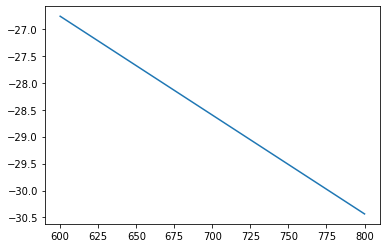

In [29]:
sns.lineplot(x=loss_plot.keys(), y=loss_plot.values())

In [30]:
# check class predict func workflow
sigmoid_input = X.dot(trained_B.T)
Yhat = sigmoid(sigmoid_input)
class_predictions = {}
i = 0
ones_count = 0
zeros_count = 0
for proba in Yhat: 
    if proba < 0.5:
        class_predictions[dtm_doc_index[i]] = (0, proba)
        zeros_count += 1
    else:
        class_predictions[dtm_doc_index[i]] = (1, proba)
        ones_count += 1
    i += 1
print(f'predicted zeros: {zeros_count}')
print(f'predicted ones: {ones_count}')
# trained on too few epochs

predicted zeros: 0
predicted ones: 59999


### 2.1. Test Logistic Regression Model

1. To see how your model is learning, first, train your model on the training data `learning rate=5e-5` (i.e., a very small number) and just use `num_steps = 1000`. 
    - Note: This means training only on 1000 emails; if your function takes a while, you might have implemented full Gradient Descent, which isn’t asked for. 

2. Make a plot of the log-likelihood for the full data every 100 steps for this initial pass. Did the model converge at some point (i.e., does the log likelihood remain stable)?

C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


<AxesSubplot:>

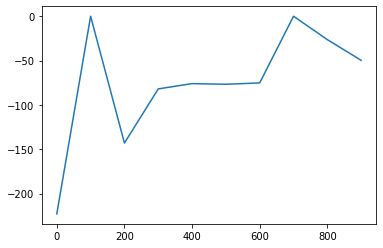

In [31]:
X = dtm.copy()
Y = np.array(labels)
learning_rate = 5e-5
num_step = 1000

X, Y, Yhat, trained_B, loss_plot, likelihood_plot = logistic_regression(X, Y, learning_rate, num_step)
sns.lineplot(x=likelihood_plot.keys(), y=likelihood_plot.values())

### 2.2. Train Logistic Regression Model

3. train the model until it converges. 
    - This will likely take several epochs, depending on your learning rate. 
    - You can stop when the log-likelihood does not change too much between steps. 
    - Typically a very small number is used (e.g., 1e-5), though you are welcome to define your own.

C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 0 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 1 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 2 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 3 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 4 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 5 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 6 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 7 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 8 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 9 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 10 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 11 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 12 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 13 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 14 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 15 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 16 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 17 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 18 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 19 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\4079591987.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(epoch)


EPOCH 20 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 21 COMPLETE
--------------------------------------------------------
EPOCH 22 COMPLETE
--------------------------------------------------------
EPOCH 23 COMPLETE
--------------------------------------------------------
EPOCH 24 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 25 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 26 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 27 COMPLETE
--------------------------------------------------------
EPOCH 28 COMPLETE
--------------------------------------------------------
EPOCH 29 COMPLETE
--------------------------------------------------------
EPOCH 30 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 31 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 32 COMPLETE
--------------------------------------------------------
EPOCH 33 COMPLETE
--------------------------------------------------------
EPOCH 34 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 35 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 36 COMPLETE
--------------------------------------------------------
EPOCH 37 COMPLETE
--------------------------------------------------------
EPOCH 38 COMPLETE
--------------------------------------------------------
EPOCH 39 COMPLETE
--------------------------------------------------------
EPOCH 40 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)
C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 41 COMPLETE
--------------------------------------------------------


C:\Users\sryanlee\AppData\Local\Temp\ipykernel_20804\1031343118.py:16: RuntimeWarning: divide by zero encountered in log
  loss = -1*yi * np.log(yi_hat) + (1-yi) * np.log(1-yi_hat)


EPOCH 42 COMPLETE
--------------------------------------------------------
EPOCH 43 COMPLETE
--------------------------------------------------------
EPOCH 44 COMPLETE
--------------------------------------------------------
EPOCH 45 COMPLETE
--------------------------------------------------------
EPOCH 46 COMPLETE
--------------------------------------------------------
EPOCH 47 COMPLETE
--------------------------------------------------------
EPOCH 48 COMPLETE
--------------------------------------------------------
EPOCH 49 COMPLETE
--------------------------------------------------------


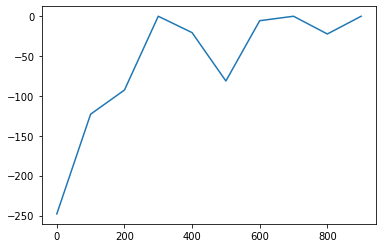

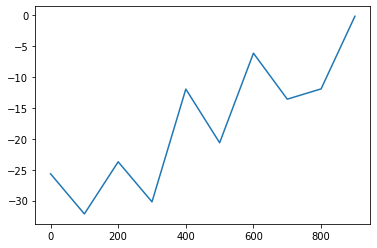

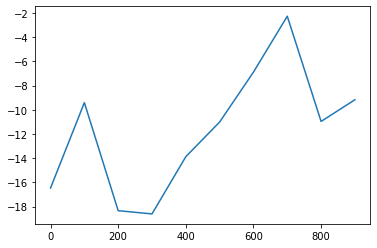

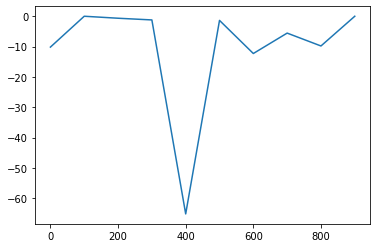

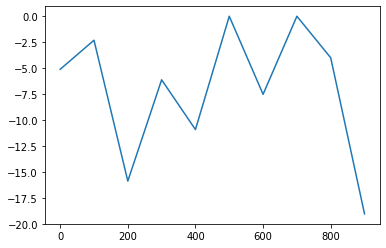

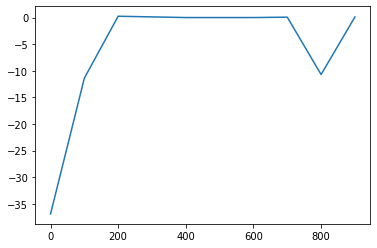

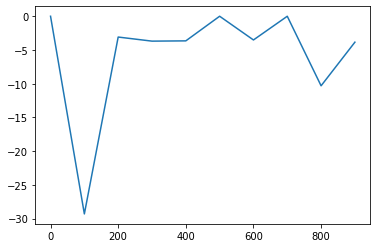

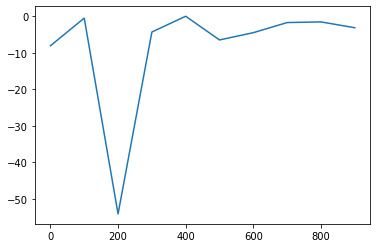

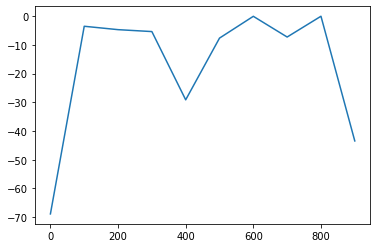

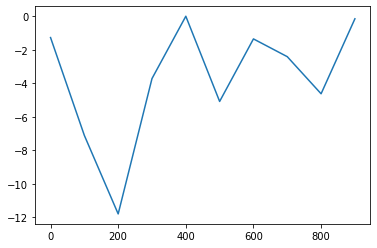

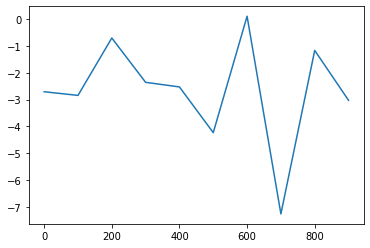

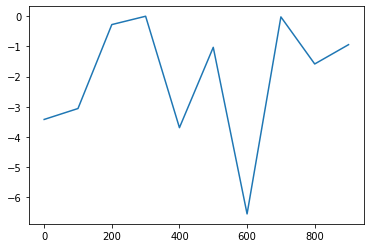

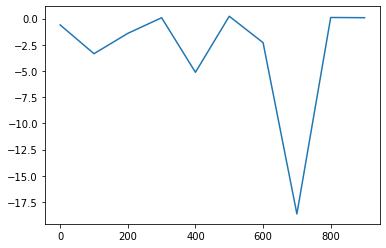

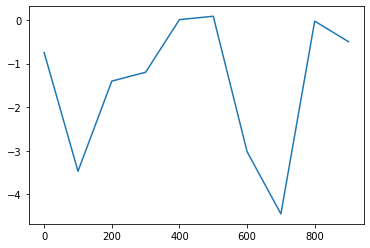

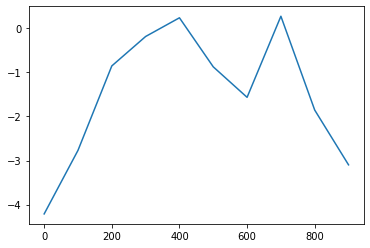

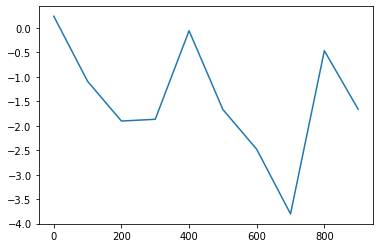

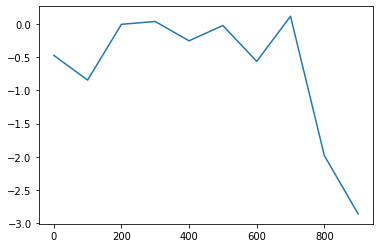

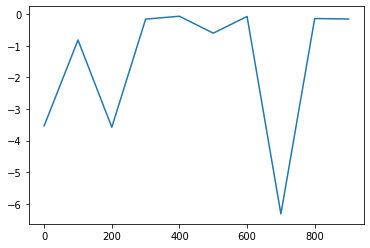

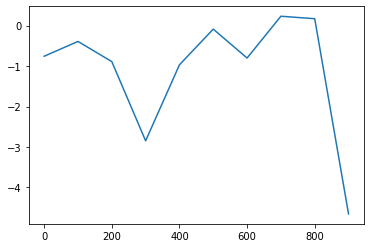

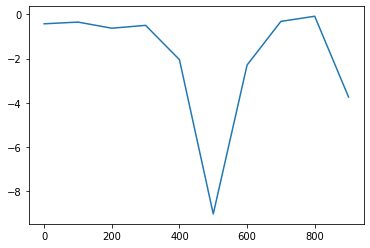

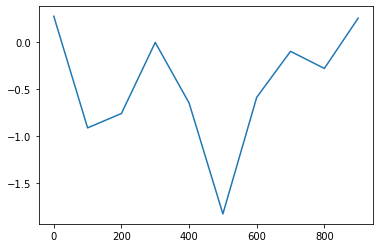

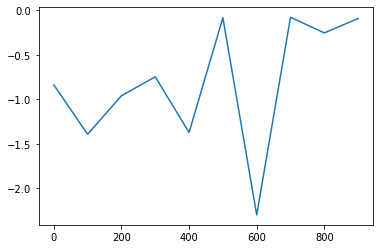

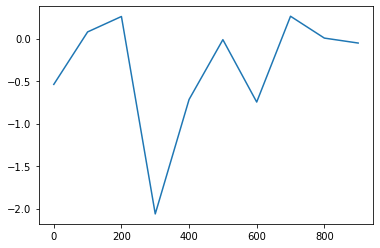

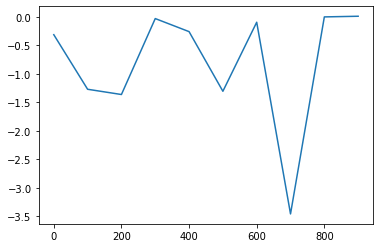

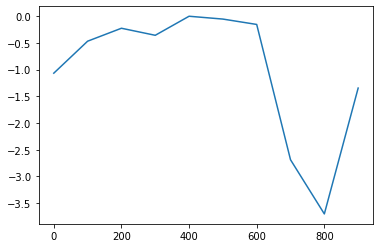

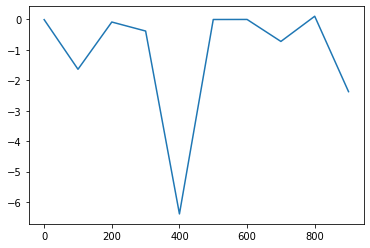

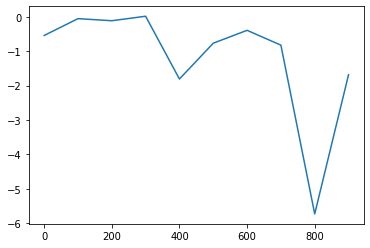

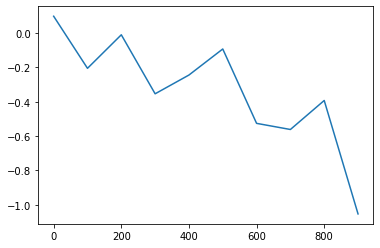

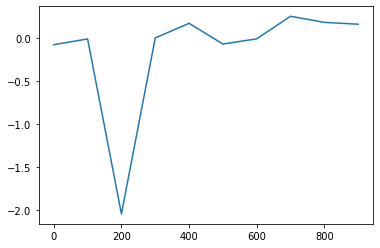

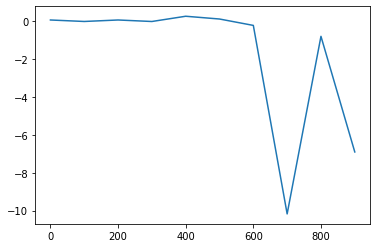

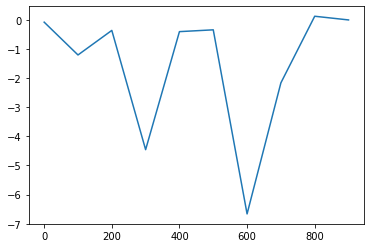

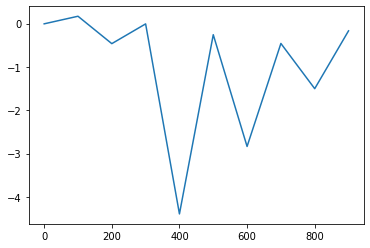

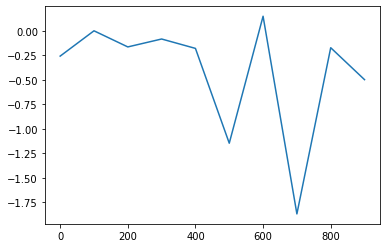

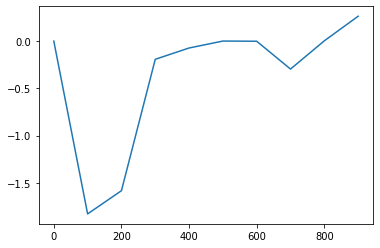

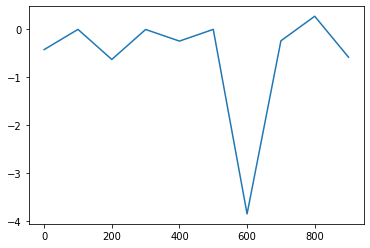

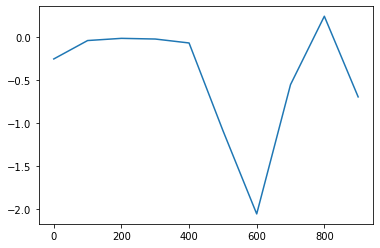

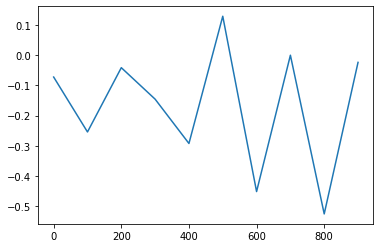

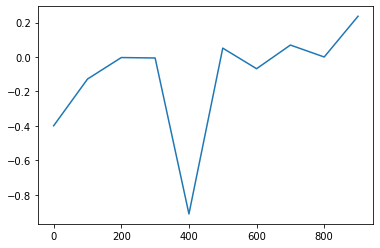

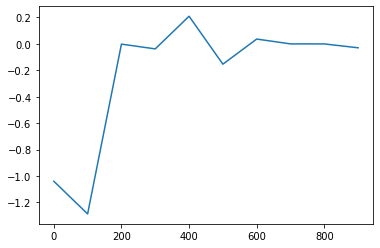

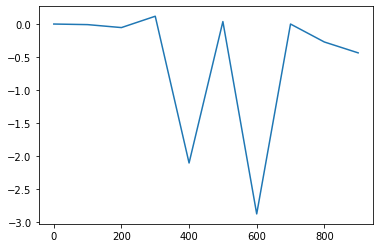

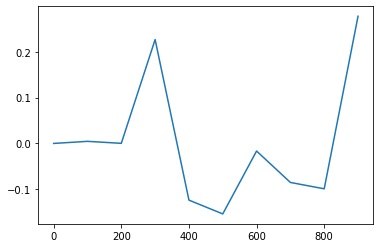

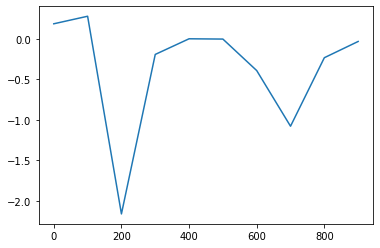

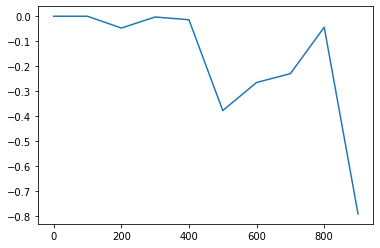

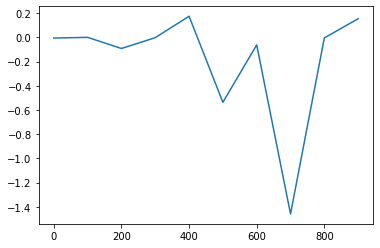

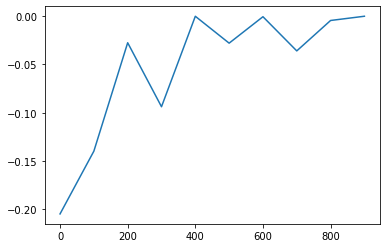

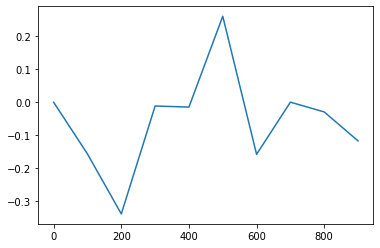

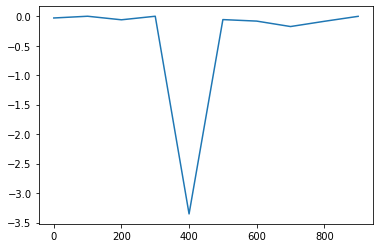

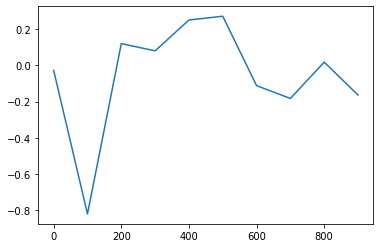

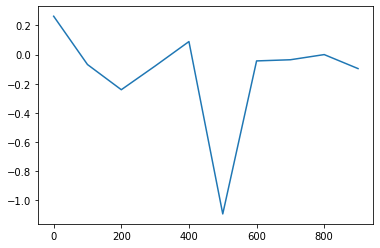

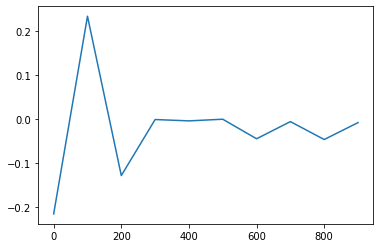

In [32]:
# did seven training rounds and ended with 50 epochs.
# in the last 5-ish epochs the likelihood remained around +/-0.5
# even after 50 epochs train probabilities are all 1.0 or .99 
X = dtm.copy()
Y = np.array(labels)
learning_rate = 1e-5
num_step = 1000
epochs = 50
likelihood_list = []
for epoch in range(epochs):
    X, Y, Yhat, trained_B, loss_plot, likelihood_plot = logistic_regression(X, Y, learning_rate, num_step, B=trained_B)
    likelihood_list.append(likelihood_plot)
    plt.figure(epoch)
    sns.lineplot(x=likelihood_plot.keys(), y=likelihood_plot.values())
    print(f'EPOCH {epoch} COMPLETE\n--------------------------------------------------------')

### 2.3. Evaluate Logistic Regression Model

4. Use your logistic regression classifier to make predictions on the validation dataset
5. Report your performance using the F1 score.
6. Submit your best model’s predictions on the test data to the [KaggleInClass](https://www.kaggle.com/c/umsi630w22hw1-1) competition for numpy Logistic Regression.
    - Use this [invite link]() **link is invalid**
    
Precision = TP / TP + FP

Recall = TP / TP + FN

F1 Score = 2*((precision*recall)/(precision+recall))

In [33]:
train_predictions, train_probabilities, true_labels = predict(email_corpus_dict, labels, trained_B)
y_actu = pd.Series(true_labels.values(), name='Actual')
y_pred = pd.Series(train_predictions.values(), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,1
Actual,
0,48340
1,11659


In [36]:
#{'uid_email': '329f4f5903d4f3ca2d48f23470932ff0', 'num_labels': 0}
print(train_predictions['329f4f5903d4f3ca2d48f23470932ff0'])
print(train_probabilities['329f4f5903d4f3ca2d48f23470932ff0'])
print(true_labels['329f4f5903d4f3ca2d48f23470932ff0'])
train_probabilities


1
1.0
0


{'3083493a6b205eabd8d0f1e7772db09b': 1.0,
 '3a583e28c820e1fac8902e4df0ef50e0': 1.0,
 '044219f46cca419d1d95242dfe036c15': 1.0,
 '68059dd1d93d0cbf456763822d1ab680': 1.0,
 '9f41a878e2839dc013546e615da83efa': 1.0,
 '59acd31d33ae14edd617edb1106141fa': 1.0,
 'c16e97b9dd7111678b726d6287c74f95': 1.0,
 '7651d68226237965e4471a1134ddd920': 1.0,
 'a4e84ace58ab33d9d6dd19d3f2bfcf15': 1.0,
 '888b9b45a84372af7005cf3f3bf7459c': 1.0,
 '60ec4754a513f4541099af479ffd8b00': 1.0,
 '07e251792932e5f0240eb84997fc605f': 1.0,
 'e1789abfb6928395bc03b53e9598a4b2': 1.0,
 '5d9f9d59aedd75ee223b2264edb885b9': 1.0,
 '329f4f5903d4f3ca2d48f23470932ff0': 1.0,
 'e0befb806efd7606f76105d04e485593': 1.0,
 '958591f1815bf6af3df51ca2a6286ba7': 1.0,
 'e77fcefc3c65bb446647af71f2228623': 1.0,
 '957cf38a3c98b7bf4b8c22abb0146c73': 1.0,
 '39fa02203520e01204346817ae0cddb2': 1.0,
 'b24118f1c9645f7897ad57c232f5677a': 1.0,
 'e606077669003611fd5195842a65a90e': 1.0,
 '64d93d8983640b5d93beabec3f881025': 1.0,
 'c7e6a5dd270a86e5b4a67c7ad042c357

## Part 3: Logistic Regression with `pytorch`

In [ ]:
# to_sparse_tensor func testing
coo = dtm.copy().tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
tensor = torch.tensor(indices, coo.data, coo.shape)
sparse_tensor = torch.sparse_coo_tensor(indices, coo.data, coo.shape)

### 3.1. Building the Logistic Regression Neural Network

To create a new newtork, you’ll extend the nn.Module class,12 which is the base class for all networks. , the class will keep track of which parameters
will need updating during gradient descent if they are assigned as a field to the class—this means we won’t have to calculate the loss like we did before or do the updating for stochastic gradient descent.

The nn.Module class defines the forward() function which is the most important function for us that we need to override. The forward function goes from the inputs to the outputs (i.e., from our bag of words vector to the predicted party). We’ll specify the inputs and then use the network layers in the method to produce our outputs.

You might also guess that there’s a backward() function too—and you’re right! That’s the step that goes from the outputs back to the inputs and updates the weights along the way. However, we don’t have to do anything here. That’s the magic: PyTorch handles the backwards updates for us and will update the β weights in our Logistic Regression model automatically as long as we call the training loop code correctly.

In this part, you’ll write a LogisticRegression class which is an extension of nn.Module. Think about: What’s the input and the output? What’s the shape of weights need to be trained? What kind of layer(s) do we have in logistic regression?

In [ ]:
class LogRegNet(nn.Module):
     def __init__(self, arguments):
        super(ToyNetwork, self).__init__()
        self.layer = nn.layer()
    
    def forward(self, inputs):
        out = nn.LogSigmoid(self.layer(inputs))
        return out
        

### 3.2. Training Setup

Define the loss function and optimizer and then use your prepared data to train the model. The loss function tells pytorch how to measure how close our predictions are to the correct outputs. In our
setting, we have a binary prediction task, so we’ll use Binary Cross Entropy Loss or `BCELoss1`. 

An optimizer object tells pytorch how to update the model’s parameters based on how wrong the model’s predictions were.  Here, we’ll use the SGD14 optimizer to start with. All of the optimizers need to know which parameters they’re updating so as a part of instantiating these objects, you’ll need to pass in your model’s parameters as an argument, which is why we need to extend the nn.Module so that all of this process works.

Training occurs in 2 steps:
1. First, you’ll run the forward pass of your code where you provide some input and the model makes a prediction
2. Then you’ll start the backwards part of the process to update the parameters to make better predictions. This is the backpropagation algorithm that calculates the updates based on how each weight in the network contributed to the ultimate prediction
    - The loss function object will calculate the loss and subsequent gradient of change for us. 
    - Then, the optimizer will update the parameters with respect to that gradient.

#### 3.2.1. Instantiate a BCELoss object that you’ll use as your loss function

#### 3.2.2. Instantiate a SGD object as your optimizer.

#### 3.2.3. Write your training loop 

The loop iterates over the data set for the specified number of epochs
and then for each step in the epoch, randomly samples one instance (row from the termdocument tensor) and gets a prediction from pytorch LogisticRegression network.

This process will look very similar to how you did your core training loop in numpy, only you’ll add in the pytorch specific bits. Use the loss function to measure the loss and then the optimizer to perform the backpropagation step (using the backwards() and step() functions.

#### 3.2.4. Write some code that during the training process, will evaluate the current model on the development data. 

You’ll want to only do this evaluation periodically (not every step) and the prediction code will be the same for the test data (though without the score). Remember the eval() call!

### 3.3. Training and Experiments

For most of these mini-experiments, you’ll be doing the same type of operation: varying one hyperparameter and then plotting the performance of the model during certain training steps. We recommend trying to refactor your code in such a way that it is easy to periodically call the evaluation step to get the model’s loss and its performance on the development data.

#### 3.3.1. Training

Like you did for the numpy code, train your model for a total of 1000 steps (i.e., only showing it 1000 randomly sampled documents) and report the loss after each 100 steps. This should verify that the loss is going down.

Once you’re satisfied that the model is working, train your model for at least 5 epochs and compute (and save) both (1) the loss every 1000 steps and (2) the F1 score of the model on the development data.

#### 3.3.2. Regularization

PyTorch builds in regularization
through the weight decay argument to most Optimizer classes (including the one you use, SGD. Let’s see what the effect is for setting the L2 penalty to 0 (default), 0.001, and 0.1.

For each L2 penalty value, train the model for 1 epoch total and plot the loss and F1 score on the development set every 1000 steps using one line for each L2 value (use separate plots for F1 vs. Loss). In a few sentences, describe what you see: What effect does L2 have on the convergence speed and overall model performance?


#### 3.3.3. Additional Optimizers

Replace your SGD optimizer with two other common alternatives RMSprop and AdamW. For each optimizer, train the model for 1 epoch total and plot the loss and F1 score on the development set every 1000 steps using one line per optimizer (use separate plots for F1 vs. Loss). In a few sentences, describe what you see: What effect does the choice in optimizer have on the convergence speed and overall model performance?


#### 3.3.4. Changing Tokenization

We had two methods for tokenizing. Does one method perform better in practice here?
Train your model in the basic setting (using SGD, no L2 loss) for 1 epoch and plot the loss and F1 score on the development set every 1000 steps using one line per optimizer (use separate plots for F1 vs. Loss). In a few sentences, describe what you see: what effect does tokenization have on the overall model performance?


#### 3.3.5. Learning Rate

What effect does the learning rate have on our model’s convergence? Using the basic setup with SGD, change the lr argument (i.e., learning rate) to a much larger and much smaller value and for 1 epoch and plot the loss and F1 score on the development set every 1000 steps using one line per lr value. Plot all three curves together and describe what you observe: what effect does the learning rate have on the model’s convergence speed? You’re welcome (encouraged, even!) to try additional learning rates. If your model converges quickly, you can also reduce the number of steps between evaluation for this question.


#### 3.3.6. Generate Predictions

Finally, use your best model to generate prediction results and report the final F1 score. Don’t forget to upload your prediction results on Kaggle